In [4]:
using LightGraphs, GraphPlot, Colors, Cairo, Compose
using LinearAlgebra: norm
using SimpleWeightedGraphs

In [5]:
# generate a random graph

function generate(Dx, Dy, N, coeff)
    xy = rand(N, 2)
    xy[:, 1] .*= Dx
    xy[:, 2] .*= Dy
        
    # ペア毎の平面距離を小さい順に並べる
    distlist = []
    for i in 1:N, j in i+1:N
        dij = norm(xy[i, :] - xy[j, :])
        push!(distlist, (i, j, dij))
    end
    sort!(distlist, by=x->x[3])
    
    # 作成するグラフ
    G = SimpleWeightedGraph(N)
    ijdij = distlist[begin]
    deleteat!(distlist, 1)
    add_edge!(G, ijdij[1], ijdij[2], ijdij[3])
    G
    
    for (u, v, duv) in distlist
        states = dijkstra_shortest_paths(G, u)
        
        if states.dists[v] == Inf
            pathuv = Int64[]
        else
            pathuv = enumerate_paths(states, v)
        end
        
        if length(pathuv) == 0
            add_edge!(G, u, v, duv)
        else
            dpathuv = states.dists[v]
            if dpathuv > duv * coeff
                add_edge!(G, u, v, duv)
            end
        end
    end
    G, xy
end

# clean up random graph (crossing edges)
"""
- Compute the intersect of two line segments if exists between L1 (p1--p2) and L2 (p3--p4)
"""
function line_segment_intersection(p1, p2, p3, p4)
    d = (p2[1] - p1[1]) * (p4[2] - p3[2]) - (p2[2] - p1[2]) * (p4[1] - p3[1])
    (d == 0.0) && return (false, -1, -1)

    intersect = [0.0, 0.0]
    u = ((p3[1] - p1[1]) * (p4[2] - p3[2]) - (p3[2] - p1[2]) * (p4[1] - p3[1])) / d
    v = ((p3[1] - p1[1]) * (p2[2] - p1[2]) - (p3[2] - p1[2]) * (p2[1] - p1[1])) / d
    if u < 0.0 || u > 1.0 || v < 0.0 || v > 1.0
        return (false, -1, -1)
    end

    px = p1[1] + u * (p2[1] - p1[1])
    py = p1[2] + u * (p2[2] - p1[2])
    if px == p1[1] && py == p1[2] ||
       px == p2[1] && py == p2[2] ||
       px == p3[1] && py == p3[2] ||
       px == p4[1] && py == p4[2]
       return (false, -1, -1)
    else
        return (true, px, py)
    end
end

function compute_first_intersections(G, pos)
    el = collect(edges(G))
    for i in 1:length(el), j in i+1:length(el)
        e1, e2 = el[i], el[j]
        (e1 == e2) && continue
        (u1, u2) = src(e1), dst(e1)
        (v1, v2) = src(e2), dst(e2)
        (G.weights[u1, u2] == 0.0) && continue
        (G.weights[v1, v2] == 0.0) && continue
        (length(Set([u1, u2, v1, v2])) < 4) && continue

        # println("$u1 $u2 $v1 $v2")
        p1, p2, p3, p4 = pos[u1, :], pos[u2, :], pos[v1, :], pos[v2, :]
        (f, px, py) = line_segment_intersection(p1, p2, p3, p4)
        (!f) && continue

        # println("$u1 $u2 $v1 $v2 $px $py")
        return [(e1, e2, px, py)]
    end
    return []
end

function clean_up(G, pos)
    computed = compute_first_intersections(G, pos)
    println("-> computed $computed")
    while length(computed) > 0
        e1, e2, px, py = computed[begin]
        deleteat!(computed, 1)
        
        # ノードと交差位置 p=(px, py) を追加
        add_vertex!(G)
        nn = nv(G)
        pos = [pos; px py]
        
        # 辺 e1 = (u1, v1) を削除して，新しく辺 (u1, p), (p, v1) を追加
        # 辺 e2 = (u2, v2) を削除して，新しく辺 (u2, p), (p, v2) を追加
        for e in [e1, e2]
            u, v = src(e), dst(e)
            dup = norm(pos[u, :] - [px, py])
            dvp = norm(pos[v, :] - [px, py])
            rem_edge!(G, e)
            add_edge!(G, u, nn, dup)
            add_edge!(G, v, nn, dvp)
            # println("add $u $nn $dup")
            # println("add $v $nn $dvp")
        end
        computed = compute_first_intersections(G, pos)
        # println("-> computed $computed")
    end
    
    
    GG = SimpleWeightedGraph(nv(G))
    for edge in edges(G)
        if edge.weight > 0.0
            add_edge!(GG, edge.src, edge.dst, edge.weight)
        end
    end
    GG, pos
end

clean_up (generic function with 1 method)

In [11]:
Dx, Dy, N, coeff = 100, 100, 50, 1.3
G, pos = generate(Dx, Dy, N, coeff)
GG, posG = clean_up(G, pos)

-> computed Tuple{SimpleWeightedEdge{Int64, Float64}, SimpleWeightedEdge{Int64, Float64}, Float64, Float64}[(Edge 5 => 9 with weight 28.553567341854574, Edge 29 => 49 with weight 25.719866817268905, 61.133541615171566, 22.49437451052357)]


({57, 115} undirected simple Int64 graph with Float64 weights, [4.340065113000802 79.25616642998008; 14.292653975340276 92.35077285209765; … ; 20.41734609921902 38.290913860536605; 71.86407785460916 52.308767526677556])

### convert SimpleWeightedGraph to Graph with Weight Matrix

In [59]:
dmat = zeros(Float64, nv(GG), nv(GG))
dmat .= Inf
for e in edges(GG)
    u, v = e.src, e.dst
    dmat[u, v] = dmat[v, u] = GG.weights[u, v]
end

### dijkstra using dmat

In [62]:
dijkstra_shortest_paths(GG, 1, dmat)
ds = dijkstra_shortest_paths(GG, s)
path_st = enumerate_paths(ds)[t]

println(ds.dists[t])
println(path_st)

123.59824239306505
[1, 19, 39, 55, 27, 14, 23, 29, 9, 8]


----
# Dijkstra

In [25]:
s = 1
t = 8 
ds = dijkstra_shortest_paths(GG, s)
path_st = enumerate_paths(ds)[t]

println(ds.dists[t])
println(path_st)

path_edge = []
for i in 1:length(path_st) - 1
    ui, uj = path_st[i], path_st[i + 1]
    ei = SimpleWeightedEdge(ui, uj, GG.weights[ui, uj])
    push!(path_edge, ei)
end

123.59824239306505
[1, 19, 39, 55, 27, 14, 23, 29, 9, 8]


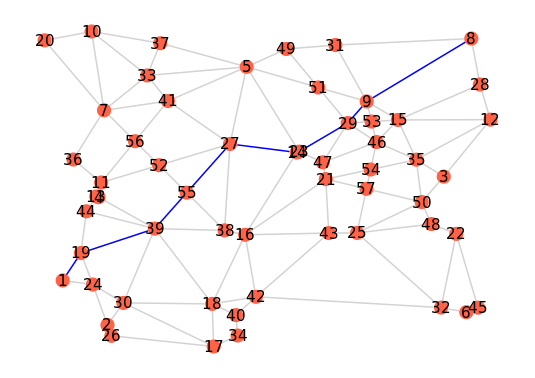

In [29]:
ec = [e in path_edge || reverse(e) in path_edge ? colorant"blue" : colorant"lightgray" for e in edges(GG)]
gp = gplot(GG, nodelabel=1:nv(GG), layout=x->(posG[:, 1], posG[:, 2]), edgestrokec=ec, nodefillc=colorant"tomato")
draw(PNG("graph.png", 12cm, 12cm), gp)
gp

----

# Graph Edge Weight Randomization

- $f_\mathrm{rand}(e) = \max(\tau, f(e) + N(0, f(e)^2 \delta^2)$

In [63]:
G = copy(GG)

# since edge is immutable, prepare a graph G and weight matrix W separately
dmat = zeros(Float64, nv(G), nv(G))
dmat .= Inf
for e in edges(G)
    u, v = e.src, e.dst
    dmat[u, v] = dmat[v, u] = GG.weights[u, v]
end

s = 1
t = 8
K = 5
τ = 0.01
delta = 0.1
paths = []
dists = []
for k in 1:K
    ds = dijkstra_shortest_paths(G, s, dmat)
    path_st = enumerate_paths(ds)[t]
    push!(dists, ds.dists[t])
    push!(paths, path_st)
    
    # update weight
    for e in edges(G)
        ow = e.weight
        nw = max(τ, e.weight + e.weight ^ 2 * delta ^ 2 * randn())
        dmat[e.src, e.dst] = dmat[e.dst, e.src] = nw
    end
end

for k in 1:K
    println(paths[k], " | ", dists[k])
end

[1, 19, 39, 55, 27, 14, 23, 29, 9, 8] | 123.59824239306505
[1, 19, 39, 38, 16, 21, 47, 29, 9, 8] | 115.90168599289804
[1, 19, 44, 13, 11, 52, 27, 14, 23, 29, 9, 8] | 101.63462818766796
[1, 19, 39, 55, 27, 14, 23, 29, 9, 8] | 104.0852344855275
[1, 19, 39, 38, 16, 21, 47, 46, 53, 9, 8] | 129.9312747043436


In [75]:
list_gp1 = []
for k in 1:K
    path_st = paths[k]
    path_edge = []
    for i in 1:length(path_st) - 1
        ui, uj = path_st[i], path_st[i + 1]
        ei = SimpleWeightedEdge(ui, uj, GG.weights[ui, uj])
        push!(path_edge, ei)
    end
    ec = [e in path_edge || reverse(e) in path_edge ? colorant"blue" : colorant"lightgray" for e in edges(GG)]
    gp = gplot(GG, nodelabel=1:nv(GG), layout=x->(posG[:, 1], posG[:, 2]), edgestrokec=ec, nodefillc=colorant"tomato")
    # draw(PNG("graph_k$k.png", 12cm, 12cm), gp)
    push!(list_gp1, gp)
end

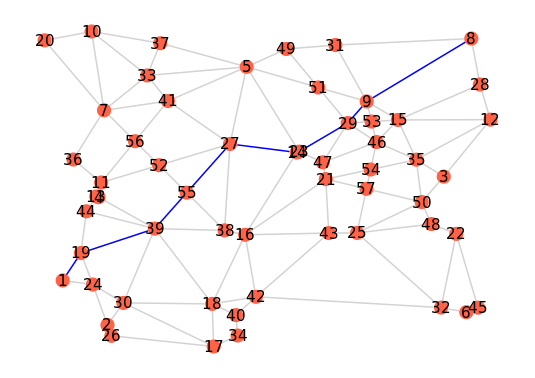

In [76]:
list_gp1[1]

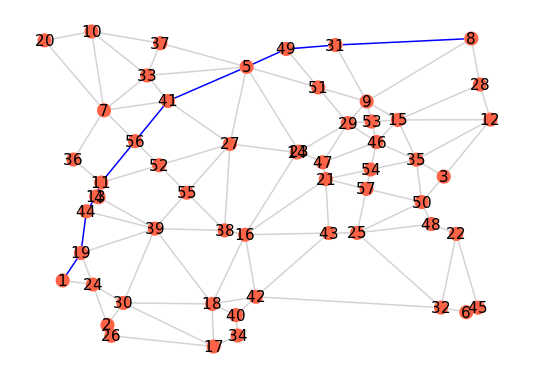

In [77]:
list_gp1[2]

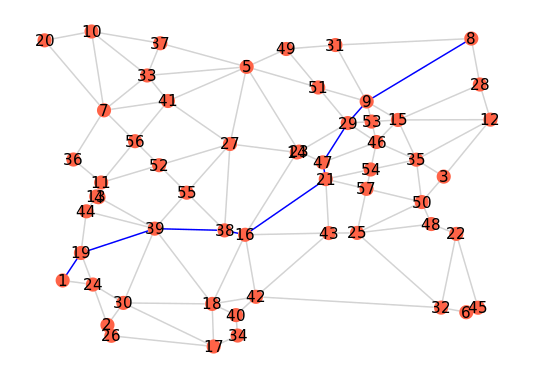

In [78]:
list_gp1[3]

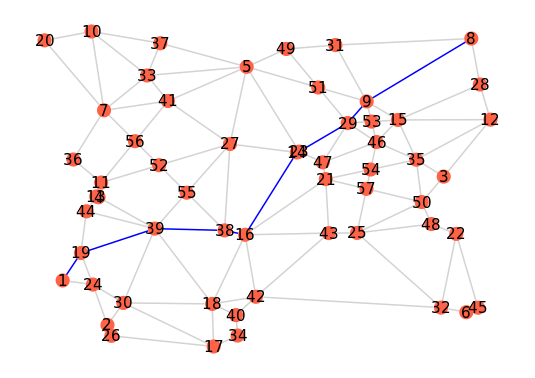

In [79]:
list_gp1[4]

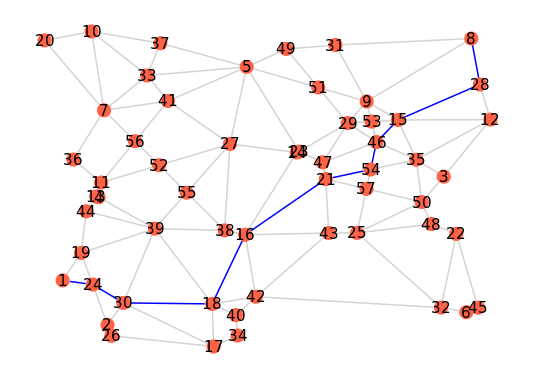

In [80]:
list_gp1[5]

----

### LightGraphs.jl, Yen

In [69]:
# bugってるらしい?
yksp = yen_k_shortest_paths(G, s, t, dmat, K)
yksp.paths

5-element Vector{Vector{Int64}}:
 [1, 19, 39, 55, 27, 14, 23, 29, 53, 15, 28, 8]
 [1, 19, 39, 55, 27, 14, 23, 29, 53, 15, 28, 8]
 [1, 19, 39, 55, 27, 14, 23, 29, 53, 15, 28, 8]
 [1, 19, 39, 55, 27, 14, 23, 29, 53, 15, 28, 8]
 [1, 19, 39, 55, 27, 14, 23, 29, 53, 15, 28, 8]

----

# Path penalization

In [85]:
G = copy(GG)

# since edge is immutable, prepare a graph G and weight matrix W separately
dmat = zeros(Float64, nv(G), nv(G))
dmat .= Inf
for e in edges(G)
    u, v = e.src, e.dst
    dmat[u, v] = dmat[v, u] = GG.weights[u, v]
end

s = 1
t = 8
p = 0.5
K = 5
paths = []
dists = []
for k in 1:K
    ds = dijkstra_shortest_paths(G, s, dmat)
    path_st = enumerate_paths(ds)[t]
    push!(dists, ds.dists[t])
    push!(paths, path_st)
    
    # update weight
    for i in 1:length(path_st) - 1
        u, v = path_st[i], path_st[i + 1]
        ow = dmat[u, v]
        nw = ow * (1 + p)
        dmat[u, v] = dmat[v, u] = nw
    end
end

for k in 1:K
    println(paths[k], " | ", dists[k])
end

[1, 19, 39, 55, 27, 14, 23, 29, 9, 8] | 123.59824239306505
[1, 19, 44, 13, 11, 56, 41, 5, 49, 31, 8] | 134.8856721525615
[1, 24, 30, 18, 16, 21, 47, 46, 15, 28, 8] | 142.13128593414407
[1, 24, 30, 39, 38, 16, 43, 25, 50, 3, 12, 28, 8] | 168.02201311877522
[1, 19, 44, 13, 11, 52, 27, 5, 51, 9, 8] | 179.42760830122086


In [86]:
list_gp2 = []
for k in 1:K
    path_st = paths[k]
    path_edge = []
    for i in 1:length(path_st) - 1
        ui, uj = path_st[i], path_st[i + 1]
        ei = SimpleWeightedEdge(ui, uj, GG.weights[ui, uj])
        push!(path_edge, ei)
    end
    ec = [e in path_edge || reverse(e) in path_edge ? colorant"blue" : colorant"lightgray" for e in edges(GG)]
    gp = gplot(GG, nodelabel=1:nv(GG), layout=x->(posG[:, 1], posG[:, 2]), edgestrokec=ec, nodefillc=colorant"tomato")
    push!(list_gp2, gp)
end

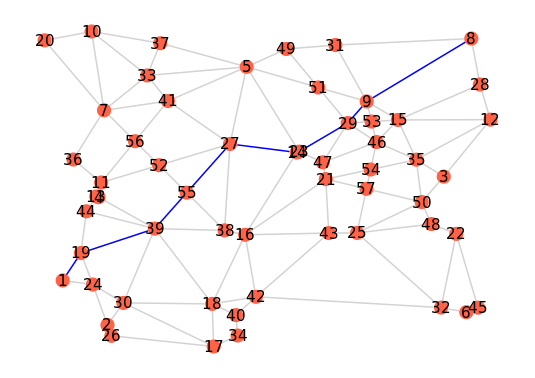

In [87]:
list_gp2[1]

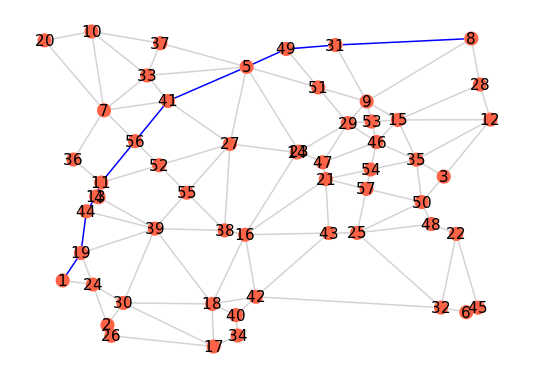

In [88]:
list_gp2[2]

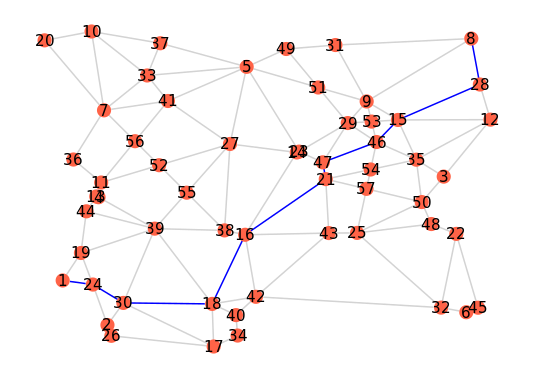

In [89]:
list_gp2[3]

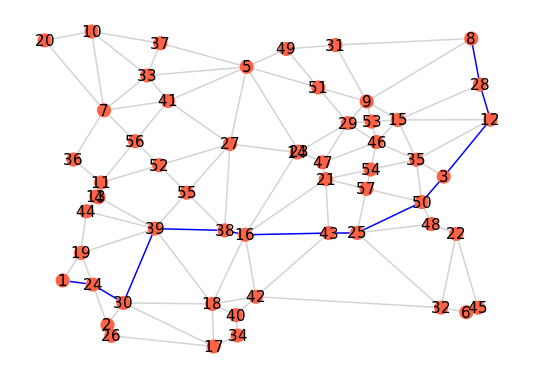

In [90]:
list_gp2[4]

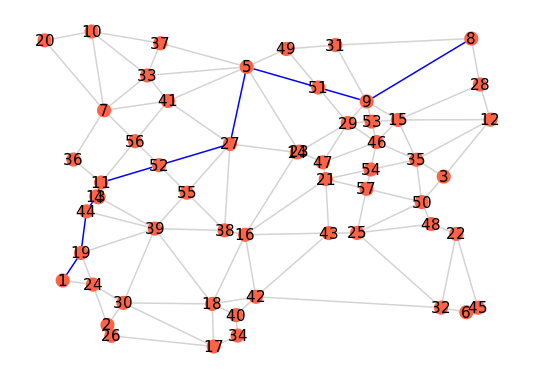

In [91]:
list_gp2[5]